In [1]:
# illustrative example of use VeraRubin 

## Creating a Local Butler for a Selected Set of Visits

> Version: 1.0
> Container Size: Large

> Description: In this notebook, we present illustrative examples of using Vera Rubin’s functions to create a local Butler for a chosen set of visits

In [2]:
# Complementary info
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Release r29.2.0 (RSP Build 2244)
lsst_distrib          gc675d380bf+f75de59d28 	current o_latest v29_2_0 v29_2_0_rc1 setup


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import VeraRubin as vr
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler

### Load the butler and show some information

In [5]:
# Initialize Butler
collection = "LSSTComCam/DP1"
repository = "dp1"

butler = Butler(config=repository, collections=collection)
# vr.ExpButler(repository=repository, collections=collection, info=False)._create_butler()

assert butler is not None

In [6]:
registry = butler.registry
dt_list = registry.queryDatasetTypes()  # datasetTypes
dt_collections = registry.queryCollections()  # collections

In [7]:
# Base Collection we want to used
collection_targets = [t.lower() for t in ["LSSTComCam/DP1", "skymaps", "LSSTComCam/raw"]]

print(f'Found {len(dt_collections)} Collections \n')
grouped_collections = {key: [] for key in collection_targets} # Dictionary to store matches grouped by category

for dt in dt_collections:
    name = dt.lower()
    for collection in collection_targets:
        if collection in name:
            grouped_collections[collection].append(dt)

# Display grouped results
print("Related Collections by Category \n")

for collection in collection_targets:
    print(f"Category: {collection}")
    if grouped_collections[collection]:
        for item in sorted(grouped_collections[collection]):
            print(f"  - {item}")
    else:
        print("  (none found)")
    print()

Found 91 Collections 

Related Collections by Category 

Category: lsstcomcam/dp1
  - LSSTComCam/DP1

Category: skymaps
  - skymaps

Category: lsstcomcam/raw
  - LSSTComCam/raw/DP1-RC2/DM-49594
  - LSSTComCam/raw/all



In [8]:
# Base datasetTypes we want to search
base_targets = [t.lower() for t in ["visit_image", "cal_exp", "calexp", "deep_coadd", "deepcoadd", "raw"]]

print(f'Found {len(dt_list)} DatasetTypes \n')
grouped = {key: [] for key in base_targets}

for dt in dt_list:  # Scan through all datasetTypes
    name = dt.name.lower()
    for base in base_targets:  # Check if the datasetType name contains any of the base targets
        if base in name:
            grouped[base].append(dt.name)

print("Related DatasetTypes by Category \n")
for base in base_targets:
    print(f"Category: {base}")
    if grouped[base]:
        for item in sorted(grouped[base]):
            print(f"  - {item}")
    else:
        print("  (none found)")
    print()

Found 592 DatasetTypes 

Related DatasetTypes by Category 

Category: visit_image
  - visit_image
  - visit_image_background

Category: cal_exp
  (none found)

Category: calexp
  (none found)

Category: deep_coadd
  - deep_coadd
  - deep_coadd_background
  - deep_coadd_n_image

Category: deepcoadd
  - assembleDeepCoadd_config
  - assembleDeepCoadd_gatherResourceUsage_config
  - assembleDeepCoadd_gatherResourceUsage_log
  - assembleDeepCoadd_gatherResourceUsage_metadata
  - assembleDeepCoadd_log
  - assembleDeepCoadd_metadata
  - deepCoadd_dcr_ddec_consolidated_map_weighted_mean
  - deepCoadd_dcr_dra_consolidated_map_weighted_mean
  - deepCoadd_dcr_e1_consolidated_map_weighted_mean
  - deepCoadd_dcr_e2_consolidated_map_weighted_mean
  - deepCoadd_epoch_consolidated_map_max
  - deepCoadd_epoch_consolidated_map_mean
  - deepCoadd_epoch_consolidated_map_min
  - deepCoadd_exposure_time_consolidated_map_sum
  - deepCoadd_psf_e1_consolidated_map_weighted_mean
  - deepCoadd_psf_e2_consolidated

## Identify visit images around location

In [9]:
# Identify visit images around location
ra_deg, dec_deg = (53.2, -27.8)
loc_data = ra_deg, dec_deg
#bands = ['u', 'r', 'i']
bands = ['u', 'i']

visit_name = base_targets[0]
print(f"Using -> {visit_name}")

visits_image_selected_list = {}
for band in bands:
    visit_refs = vr.visit_dataset(butler, band, loc_data, use_patch_area=False, detectors=None, timespan=None, visit_ids=None)
    print(f'[INF] Found {len(visit_refs)} visits in band {band}')
    visits_image_selected_list[band] = visit_refs  # Saving the visit data set per band

Using -> visit_image
[INF] Found 31 visits in band u
[INF] Found 114 visits in band i


In [10]:
# Data example
print(visits_image_selected_list['u'][0].dataId) # datasetType dimensions run dataId

{instrument: 'LSSTComCam', detector: 2, visit: 2024110900195, band: 'u', day_obs: 20241109, physical_filter: 'u_02'}


### Selecting the visits from *visit_image*

Sorting the *visit_image* visits by their quality

> [IMPORTANT]: The final version used the Alma filters

In [11]:
visits_selected_sort_list = {}
for band, visit_calexp_dataset in visits_image_selected_list.items():
    snr_list, valid_refs = [], []
    n_visits = len(visit_calexp_dataset)
    
    for k, ref in enumerate(visit_calexp_dataset):
        vr.progressbar(k, n_visits-1)
        try:
            exp = butler.get(visit_name, dataId=(ref.dataId))
            snr = vr.measure_quality(exp)
            
            snr_list.append(snr)
            valid_refs.append(ref)
            del exp  # free memory early
        except Exception as e:
            print(f"[ERROR] Could not load exposure {ref.dataId}: {e}")

    # Sort by SNR
    if len(snr_list) == 0:
        print(f"[WARNING] No valid exposures for band {band}")
        visits_selected_sort_list[band] = []
        getWcs_selected_sort_list[band] = []
        continue
    
    # Sort by SNR
    sorter_snr = np.argsort(snr_list)[::-1]  # descending
    visits_selected_sort_list[band] = [valid_refs[i] for i in sorter_snr]

Progress: [####################] 100%
Progress: [####################] 100%


In [12]:
# taking the first four with best quality
nbest = 4

visits_u = visits_selected_sort_list['u'][:nbest]
visits_i = visits_selected_sort_list['i'][:nbest]

In [13]:
visits_i[0]

DatasetRef(DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCam', detector: 5, visit: 2024110800303, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=60eb01dc-fcb3-4c76-98b5-57b1b0c79749)

### Creating the local butler repository and copying the visits

In [14]:
# General CONFIGURATION
LOCAL_REPO = "./local_butler"       # Local butler repo path
REMOTE_REPO = vr.get_butler_location(butler)  # Remote butler repo path

In [15]:
# Making a local butler repo and copying the visits_u
vr.main_local_repo(
    LOCAL_REPO, 
    REMOTE_REPO,
    visits_datasetRef=visits_u,
    remote_collection="LSSTComCam/DP1",
    LOGDIR="local_butler/logs_u",
    chain_name="local_main_chain",
    make_repo=True)

2025-12-22 22:39:03 [INFO] Created LOGDIR at local_butler/logs_u


2025-12-22 22:39:03 [INFO] Starting pipeline for local repo: ./local_butler


2025-12-22 22:39:03 [INFO] Creating empty repo at ./local_butler


2025-12-22 22:39:03 [INFO] Creating Butler repo at ./local_butler


2025-12-22 22:39:03 [INFO] Empty repo created successfully.


2025-12-22 22:39:03 [INFO] Registering instruments: ['LSSTComCam']


2025-12-22 22:39:03 [INFO] Detected instruments to register: ['LSSTComCam']


2025-12-22 22:39:03 [INFO] Opening remote Butler: https://data.lsst.cloud/api/butler/repo/dp1/ (collections=LSSTComCam/DP1)


2025-12-22 22:39:03 [INFO] [CMD] butler register-instrument ./local_butler lsst.obs.lsst.LsstComCam


2025-12-22 22:39:11 [INFO] 


2025-12-22 22:39:11 [INFO] Registered instrument 'LSSTComCam' -> lsst.obs.lsst.LsstComCam


2025-12-22 22:39:11 [INFO] Instrument registration complete.


2025-12-22 22:39:11 [INFO] Starting visits transfer loop


2025-12-22 22:39:11 [INFO] 
[VISIT] Processing visit 2024113000172


2025-12-22 22:39:11 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:39:11 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 0, visit: 2024113000172, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:39:11 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:39:11 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:39:11 [INFO]   Optional present : []


2025-12-22 22:39:11 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:39:11 [WARNING] [WARN] Required datasets missing for visit 2024113000172: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:39:11 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:39:11 [INFO] Registered DatasetType: visit_image


2025-12-22 22:39:11 [INFO] Registered DatasetType: raw


2025-12-22 22:39:11 [INFO] Registered DatasetType: visit_summary


2025-12-22 22:39:11 [INFO] DatasetType registration complete.


2025-12-22 22:39:11 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024113000172


2025-12-22 22:39:11 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:11 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000172) AND band='u' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:39:20 [INFO] Number of datasets transferred: 9


2025-12-22 22:39:20 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:39:20 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024113000172)


2025-12-22 22:39:20 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024113000172


2025-12-22 22:39:20 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:20 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000172) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:39:31 [INFO] Number of datasets transferred: 9


2025-12-22 22:39:31 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:39:31 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024113000172)


2025-12-22 22:39:31 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024113000172


2025-12-22 22:39:31 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:31 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000172) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:39:39 [INFO] Number of datasets transferred: 1


2025-12-22 22:39:39 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024113000172)


2025-12-22 22:39:39 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 0, visit: 2024113000172, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:39:39 [INFO] 
[VISIT] Processing visit 2024113000176


2025-12-22 22:39:39 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:39:39 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 3, visit: 2024113000176, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:39:39 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:39:39 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:39:39 [INFO]   Optional present : []


2025-12-22 22:39:39 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:39:39 [WARNING] [WARN] Required datasets missing for visit 2024113000176: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:39:39 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:39:39 [INFO] DatasetType registration complete.


2025-12-22 22:39:39 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024113000176


2025-12-22 22:39:39 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:39 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000176) AND band='u' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:39:48 [INFO] Number of datasets transferred: 9


2025-12-22 22:39:48 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:39:48 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024113000176)


2025-12-22 22:39:48 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024113000176


2025-12-22 22:39:48 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:48 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000176) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:39:59 [INFO] Number of datasets transferred: 9


2025-12-22 22:39:59 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:39:59 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024113000176)


2025-12-22 22:39:59 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024113000176


2025-12-22 22:39:59 [INFO] [INFO] Transferring visits...


2025-12-22 22:39:59 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000176) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:40:07 [INFO] Number of datasets transferred: 1


2025-12-22 22:40:07 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024113000176)


2025-12-22 22:40:07 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 3, visit: 2024113000176, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:40:07 [INFO] 
[VISIT] Processing visit 2024113000175


2025-12-22 22:40:07 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:40:08 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 3, visit: 2024113000175, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:40:08 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:40:08 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:40:08 [INFO]   Optional present : []


2025-12-22 22:40:08 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:40:08 [WARNING] [WARN] Required datasets missing for visit 2024113000175: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:40:08 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:40:08 [INFO] DatasetType registration complete.


2025-12-22 22:40:08 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024113000175


2025-12-22 22:40:08 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:08 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000175) AND band='u' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:40:17 [INFO] Number of datasets transferred: 9


2025-12-22 22:40:17 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:40:17 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024113000175)


2025-12-22 22:40:17 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024113000175


2025-12-22 22:40:17 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:17 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000175) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:40:27 [INFO] Number of datasets transferred: 9


2025-12-22 22:40:27 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:40:27 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024113000175)


2025-12-22 22:40:27 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024113000175


2025-12-22 22:40:27 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:27 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024113000175) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:40:35 [INFO] Number of datasets transferred: 1


2025-12-22 22:40:35 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024113000175)


2025-12-22 22:40:35 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 3, visit: 2024113000175, band: 'u', day_obs: 20241130, physical_filter: 'u_02'}


2025-12-22 22:40:35 [INFO] 
[VISIT] Processing visit 2024120100190


2025-12-22 22:40:35 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:40:35 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 0, visit: 2024120100190, band: 'u', day_obs: 20241201, physical_filter: 'u_02'}


2025-12-22 22:40:35 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:40:35 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:40:35 [INFO]   Optional present : []


2025-12-22 22:40:35 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:40:35 [WARNING] [WARN] Required datasets missing for visit 2024120100190: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:40:35 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:40:35 [INFO] DatasetType registration complete.


2025-12-22 22:40:35 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024120100190


2025-12-22 22:40:35 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:35 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120100190) AND band='u' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:40:43 [INFO] Number of datasets transferred: 9


2025-12-22 22:40:43 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:40:43 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024120100190)


2025-12-22 22:40:43 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024120100190


2025-12-22 22:40:43 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:43 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120100190) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:40:54 [INFO] Number of datasets transferred: 8


2025-12-22 22:40:54 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 8 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:40:54 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024120100190)


2025-12-22 22:40:54 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024120100190


2025-12-22 22:40:54 [INFO] [INFO] Transferring visits...


2025-12-22 22:40:54 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120100190) AND band='u' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:41:02 [INFO] Number of datasets transferred: 1


2025-12-22 22:41:02 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024120100190)


2025-12-22 22:41:02 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 0, visit: 2024120100190, band: 'u', day_obs: 20241201, physical_filter: 'u_02'}


2025-12-22 22:41:02 [INFO] Registering DatasetType 'skyMap' in local repo before transfer.


2025-12-22 22:41:02 [INFO] Registered DatasetType: skyMap


2025-12-22 22:41:02 [INFO] Copying skyMap(s) from remote to local (preserving UUIDs)...


2025-12-22 22:41:03 [INFO] [SKYMAP] SkyMap dimension found: lsst_cells_v1


2025-12-22 22:41:04 [INFO] [SKYMAP] Found skyMap dataset in collection: skymaps


2025-12-22 22:41:04 [INFO] [SKYMAP] Found skyMap dataset in collection: LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260


2025-12-22 22:41:04 [INFO] [SKYMAP] Found skyMap dataset in collection: LSSTComCam/DP1


2025-12-22 22:41:04 [INFO] [SKYMAP] SkyMap dataset stored in RUN: skymaps


2025-12-22 22:41:04 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --dataset-type skyMap --collections skymaps


Number of datasets transferred: 1
2025-12-22 22:41:12 [INFO] [SKYMAP] SkyMap successfully transferred.


2025-12-22 22:41:12 [INFO] SkyMap copy finished.


2025-12-22 22:41:12 [INFO] Creating chained collection 'local_main_chain' that includes existing local collections.


2025-12-22 22:41:13 [INFO] Registered CHAINED collection: local_main_chain


2025-12-22 22:41:13 [INFO] Set chain for 'local_main_chain' -> ['LSSTComCam/raw/all', 'LSSTComCam/runs/DRP/DP1/DM-51335', 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260/20250416T185152Z', 'skymaps']


2025-12-22 22:41:13 [INFO] Pipeline finished successfully.


True

### Visualizing some repo information

In [16]:
#from lsst.daf.butler import Butler

lbutler = Butler(LOCAL_REPO) #, writeable=True)

# check the collection name and data_set type
registry = lbutler.registry
colections = registry.queryCollections()
print("List of avalibles colections disponibles:", colections)

print()
dt_list = registry.queryDatasetTypes()
print("List of valaibles datasetType:", dt_list)

List of avalibles colections disponibles: ['LSSTComCam/raw/all', 'LSSTComCam/runs/DRP/DP1/DM-51335', 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260/20250416T185152Z', 'skymaps', 'local_main_chain']

List of valaibles datasetType: [DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), DatasetType('visit_summary', {band, instrument, day_obs, physical_filter, visit}, ExposureCatalog), DatasetType('skyMap', {skymap}, SkyMap)]


In [17]:
# list(lbutler.registry.queryDimensionRecords("patch"))

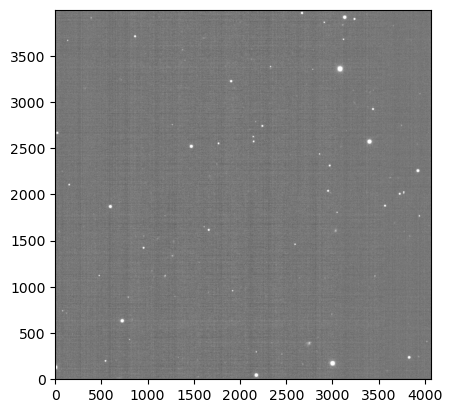

In [18]:
# visualizating 

id_visit = {'instrument': 'LSSTComCam', 'detector': 8,
            'visit': 2024113000175, 'band': 'u', 
            'day_obs': 20241130, 'physical_filter': 'u_02'} 

img = lbutler.get('visit_image', dataId=id_visit, #visits_u[0].dataId,
                  collections=colections[1]).getImage().getArray()

p5, p95 = np.nanpercentile(img, [0.01, 99.9])
plt.imshow(img, origin='lower', cmap='gray', vmin=p5, vmax=p95)

### Adding to the local repo,the i-band

In [19]:
vr.main_local_repo(
    LOCAL_REPO, 
    REMOTE_REPO,
    visits_datasetRef=visits_i,
    remote_collection="LSSTComCam/DP1",
    LOGDIR="local_butler/logs_u",
    chain_name="local_main_chain",
    make_repo=False)

2025-12-22 22:41:18 [INFO] Created LOGDIR at local_butler/logs_u


2025-12-22 22:41:18 [INFO] Starting pipeline for local repo: ./local_butler


2025-12-22 22:41:18 [INFO] Registering instruments: ['LSSTComCam']


2025-12-22 22:41:18 [INFO] Detected instruments to register: ['LSSTComCam']


2025-12-22 22:41:18 [INFO] Opening remote Butler: https://data.lsst.cloud/api/butler/repo/dp1/ (collections=LSSTComCam/DP1)


2025-12-22 22:41:18 [INFO] Instrument 'LSSTComCam' already registered locally — skipping.


2025-12-22 22:41:18 [INFO] Instrument registration complete.


2025-12-22 22:41:18 [INFO] Starting visits transfer loop


2025-12-22 22:41:18 [INFO] 
[VISIT] Processing visit 2024110800303


2025-12-22 22:41:18 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:41:19 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 5, visit: 2024110800303, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}


2025-12-22 22:41:19 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:41:19 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:41:19 [INFO]   Optional present : []


2025-12-22 22:41:19 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:41:19 [WARNING] [WARN] Required datasets missing for visit 2024110800303: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:41:19 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:41:19 [INFO] DatasetType registration complete.


2025-12-22 22:41:19 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024110800303


2025-12-22 22:41:19 [INFO] [INFO] Transferring visits...


2025-12-22 22:41:19 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800303) AND band='i' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:41:28 [INFO] Number of datasets transferred: 9


2025-12-22 22:41:28 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:41:28 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024110800303)


2025-12-22 22:41:28 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024110800303


2025-12-22 22:41:28 [INFO] [INFO] Transferring visits...


2025-12-22 22:41:28 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800303) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:41:38 [INFO] Number of datasets transferred: 9


2025-12-22 22:41:38 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:41:38 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024110800303)


2025-12-22 22:41:38 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024110800303


2025-12-22 22:41:38 [INFO] [INFO] Transferring visits...


2025-12-22 22:41:38 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800303) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:41:46 [INFO] Number of datasets transferred: 1


2025-12-22 22:41:46 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024110800303)


2025-12-22 22:41:46 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 5, visit: 2024110800303, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}


2025-12-22 22:41:46 [INFO] 
[VISIT] Processing visit 2024120300127


2025-12-22 22:41:46 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:41:47 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 5, visit: 2024120300127, band: 'i', day_obs: 20241203, physical_filter: 'i_06'}


2025-12-22 22:41:47 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:41:47 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:41:47 [INFO]   Optional present : []


2025-12-22 22:41:47 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:41:47 [WARNING] [WARN] Required datasets missing for visit 2024120300127: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:41:47 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:41:47 [INFO] DatasetType registration complete.


2025-12-22 22:41:47 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024120300127


2025-12-22 22:41:47 [INFO] [INFO] Transferring visits...


2025-12-22 22:41:47 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300127) AND band='i' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:41:55 [INFO] Number of datasets transferred: 9


2025-12-22 22:41:55 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:41:55 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024120300127)


2025-12-22 22:41:55 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024120300127


2025-12-22 22:41:55 [INFO] [INFO] Transferring visits...


2025-12-22 22:41:55 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300127) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:42:06 [INFO] Number of datasets transferred: 9


2025-12-22 22:42:06 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:42:06 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024120300127)


2025-12-22 22:42:06 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024120300127


2025-12-22 22:42:06 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:06 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300127) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:42:14 [INFO] Number of datasets transferred: 1


2025-12-22 22:42:14 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024120300127)


2025-12-22 22:42:14 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 5, visit: 2024120300127, band: 'i', day_obs: 20241203, physical_filter: 'i_06'}


2025-12-22 22:42:14 [INFO] 
[VISIT] Processing visit 2024120300128


2025-12-22 22:42:14 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:42:14 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 5, visit: 2024120300128, band: 'i', day_obs: 20241203, physical_filter: 'i_06'}


2025-12-22 22:42:14 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:42:14 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:42:14 [INFO]   Optional present : []


2025-12-22 22:42:14 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:42:14 [WARNING] [WARN] Required datasets missing for visit 2024120300128: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:42:14 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:42:15 [INFO] DatasetType registration complete.


2025-12-22 22:42:15 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024120300128


2025-12-22 22:42:15 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:15 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300128) AND band='i' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:42:23 [INFO] Number of datasets transferred: 9


2025-12-22 22:42:23 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:42:23 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024120300128)


2025-12-22 22:42:23 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024120300128


2025-12-22 22:42:23 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:23 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300128) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:42:34 [INFO] Number of datasets transferred: 9


2025-12-22 22:42:34 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:42:34 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024120300128)


2025-12-22 22:42:34 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024120300128


2025-12-22 22:42:34 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:34 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024120300128) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:42:42 [INFO] Number of datasets transferred: 1


2025-12-22 22:42:42 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024120300128)


2025-12-22 22:42:42 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 5, visit: 2024120300128, band: 'i', day_obs: 20241203, physical_filter: 'i_06'}


2025-12-22 22:42:42 [INFO] 
[VISIT] Processing visit 2024110800252


2025-12-22 22:42:42 [INFO] Getting the remote Butler registry on: https://data.lsst.cloud/api/butler/repo/dp1/.


2025-12-22 22:42:42 [INFO] [DISCOVER] Visit {instrument: 'LSSTComCam', detector: 5, visit: 2024110800252, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}


2025-12-22 22:42:42 [INFO]   Required present : ['raw', 'visit_image', 'visit_summary']


2025-12-22 22:42:42 [INFO]   Missing required : ['calexp', 'calexp_background', 'calexp_metadata', 'calexp_noise', 'calexp_psf', 'calexp_wcs', 'postISRCCD', 'visit_summary_metadata', 'visit_summary_schema']


2025-12-22 22:42:42 [INFO]   Optional present : []


2025-12-22 22:42:42 [INFO]   Missing optional : ['calexp_background_model', 'postISRCCD', 'postISRCCD_metadata', 'src', 'srcMatchFull', 'srcMatches', 'src_schema', 'src_schema_validity']


2025-12-22 22:42:42 [WARNING] [WARN] Required datasets missing for visit 2024110800252: {'calexp_psf', 'visit_summary_schema', 'visit_summary_metadata', 'calexp', 'calexp_wcs', 'postISRCCD', 'calexp_metadata', 'calexp_background', 'calexp_noise'}


2025-12-22 22:42:42 [INFO] Registering DatasetTypes: ['visit_image', 'raw', 'visit_summary']


2025-12-22 22:42:43 [INFO] DatasetType registration complete.


2025-12-22 22:42:43 [INFO] [TRANSFER] Copying datasetType 'raw' for visit=2024110800252


2025-12-22 22:42:43 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:43 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800252) AND band='i' --collections LSSTComCam/DP1 --dataset-type raw


2025-12-22 22:42:51 [INFO] Number of datasets transferred: 9


2025-12-22 22:42:51 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:42:51 [INFO] Completed transfer-datasets for dataset=raw, visits=(2024110800252)


2025-12-22 22:42:51 [INFO] [TRANSFER] Copying datasetType 'visit_image' for visit=2024110800252


2025-12-22 22:42:51 [INFO] [INFO] Transferring visits...


2025-12-22 22:42:51 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800252) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_image


2025-12-22 22:43:01 [INFO] Number of datasets transferred: 9


2025-12-22 22:43:01 [WARNING] lsst.daf.butler.direct_butler._direct_butler INFO: Importing 9 datasets into Butler(collections=DirectButlerCollections(defaults=()), run=None, datastore='file:///home/arestrada88/WORK/Alma_proyect/local_butler/', registry='SQLite3@/home/arestrada88/WORK/Alma_proyect/local_butler/gen3.sqlite3')


2025-12-22 22:43:01 [INFO] Completed transfer-datasets for dataset=visit_image, visits=(2024110800252)


2025-12-22 22:43:01 [INFO] [TRANSFER] Copying datasetType 'visit_summary' for visit=2024110800252


2025-12-22 22:43:01 [INFO] [INFO] Transferring visits...


2025-12-22 22:43:01 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --where instrument='LSSTComCam' AND visit IN (2024110800252) AND band='i' --collections LSSTComCam/DP1 --dataset-type visit_summary


2025-12-22 22:43:09 [INFO] Number of datasets transferred: 1


2025-12-22 22:43:09 [INFO] Completed transfer-datasets for dataset=visit_summary, visits=(2024110800252)


2025-12-22 22:43:09 [INFO] Transfer succeeded for dataId: {instrument: 'LSSTComCam', detector: 5, visit: 2024110800252, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}


2025-12-22 22:43:09 [INFO] Registering DatasetType 'skyMap' in local repo before transfer.


2025-12-22 22:43:09 [INFO] Copying skyMap(s) from remote to local (preserving UUIDs)...


2025-12-22 22:43:10 [INFO] [SKYMAP] SkyMap dimension found: lsst_cells_v1


2025-12-22 22:43:11 [INFO] [SKYMAP] Found skyMap dataset in collection: skymaps


2025-12-22 22:43:12 [INFO] [SKYMAP] Found skyMap dataset in collection: LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260


2025-12-22 22:43:12 [INFO] [SKYMAP] Found skyMap dataset in collection: LSSTComCam/DP1


2025-12-22 22:43:12 [INFO] [SKYMAP] SkyMap dataset stored in RUN: skymaps


2025-12-22 22:43:12 [INFO] [CMD] butler transfer-datasets https://data.lsst.cloud/api/butler/repo/dp1/ ./local_butler --dataset-type skyMap --collections skymaps


lsst.daf.butler.datastores.fileDatastore INFO: Skipped transfer of 1 dataset already present in datastore


Number of datasets transferred: 1
2025-12-22 22:43:19 [INFO] [SKYMAP] SkyMap successfully transferred.


2025-12-22 22:43:19 [INFO] SkyMap copy finished.


2025-12-22 22:43:19 [INFO] Creating chained collection 'local_main_chain' that includes existing local collections.


2025-12-22 22:43:20 [INFO] Set chain for 'local_main_chain' -> ['LSSTComCam/raw/all', 'LSSTComCam/runs/DRP/DP1/DM-51335', 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260/20250416T185152Z', 'skymaps']


2025-12-22 22:43:20 [INFO] Pipeline finished successfully.


True

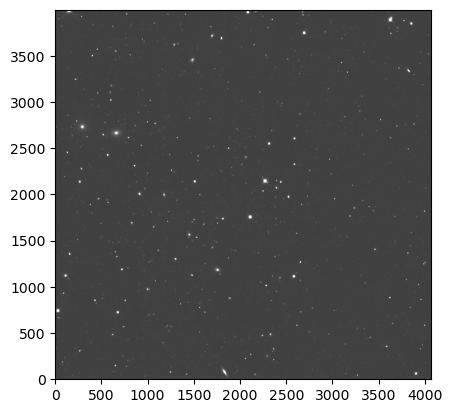

In [20]:
# visualizating 

id_visit = {'instrument': 'LSSTComCam', 'detector': 5,
            'visit': 2024110800303, 'band': 'i', 
            'day_obs': 20241108, 'physical_filter': 'i_06'}

img = lbutler.get('visit_image', dataId=id_visit, #visits_i[-1].dataId,
                  collections=colections[1]).getImage().getArray()

p5, p95 = np.nanpercentile(img, [0.01, 99.9])
plt.imshow(img, origin='lower', cmap='gray', vmin=p5, vmax=p95)